# Dataset

ETTh1 dataset is a dataset of Eletricity transformers across 2 counties in China. In this project, we compare between the performance of transformer-based autoencoder architecture with and without the Masked Autoencoder (MAE) method.

- https://github.com/zhouhaoyi/ETDataset/tree/main/ETT-small
- https://arxiv.org/pdf/2111.06377.pdf

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import time
import os

In [2]:
# functions

def prepare_dataframe_for_lstm(df, n_steps, date_col_name, value_col_name):
    df = dc(df)
    df.set_index(date_col_name, inplace=True)
    for i in range(1, n_steps+1):
        df[f'{value_col_name}(t-{i})'] = df[value_col_name].shift(i)
    df.dropna(inplace=True)
    return df

In [3]:
# define dataloader class
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

cpu


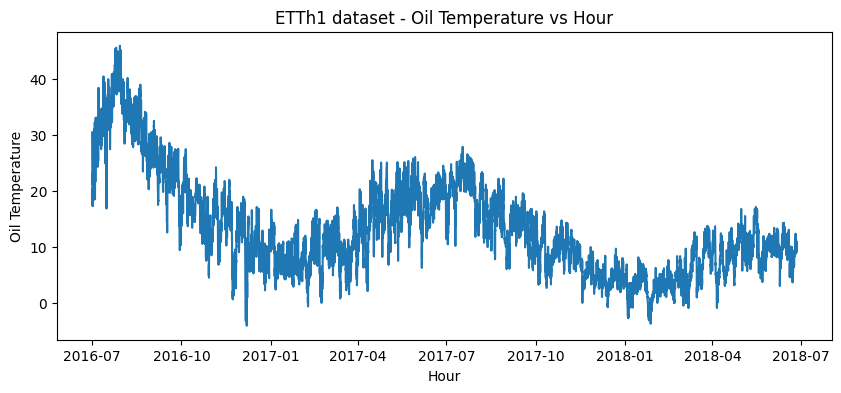

(17320, 101)
(17320, 100) (17320,)
(12124, 100) (3464, 100) (1732, 100)
(12124,) (3464,) (1732,)
(12124, 100, 1) (3464, 100, 1) (1732, 100, 1)
(12124, 1) (3464, 1) (1732, 1)
torch.Size([12124, 100, 1]) torch.Size([3464, 100, 1]) torch.Size([1732, 100, 1])
torch.Size([12124, 1]) torch.Size([3464, 1]) torch.Size([1732, 1])
torch.Size([512, 100, 1]) torch.Size([512, 1])


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  import sys


In [4]:
# data preprocessing 

batch_size = 512
train_size,val_size,test_size = 0.7,0.2,0.1
lookback = 100

date_col_name,value_col_name = 'date','OT'

csvPath = '~/Desktop/own-development-dsa5204-project/data/ETTh1.csv'

data = pd.read_csv(csvPath)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

data = data[[date_col_name,value_col_name]]
data[date_col_name] = pd.to_datetime(data[date_col_name])
plt.figure(figsize=(10,4))
plt.plot(data[date_col_name], data[value_col_name])
plt.title('ETTh1 dataset - Oil Temperature vs Hour')
plt.xlabel('Hour')
plt.ylabel('Oil Temperature')
plt.show()


shifted_df = prepare_dataframe_for_lstm(data, lookback, date_col_name, value_col_name)
shifted_df

# format X and y from df and scale it
shifted_df_as_np = shifted_df.to_numpy()
print(shifted_df_as_np.shape)

# normalise the data
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]
print(X.shape, y.shape)
X = dc(np.flip(X, axis=1))

# train test split
X_train = X[:int(len(X) * train_size)]
X_val = X[int(len(X) * train_size):int(len(X) * train_size)+int(len(X) * val_size)]
X_test = X[int(len(X) * train_size)+int(len(X) * val_size):]

y_train = y[:int(len(y) * train_size)]
y_val = y[int(len(y) * train_size):int(len(y) * train_size)+int(len(y) * val_size)]
y_test = y[int(len(y) * train_size)+int(len(y) * val_size):]
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

X_train = X_train.reshape((-1, lookback, 1))
X_val = X_val.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))
y_train = y_train.reshape((-1, 1))
y_val = y_val.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

X_train = torch.tensor(X_train).float()
X_val = torch.tensor(X_val).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_val = torch.tensor(y_val).float()
y_test = torch.tensor(y_test).float()
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)


train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True) # set all shuffle=False since its sequential data
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

# print to check
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

# Models
- with MAE
- without MAE

In [5]:
# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [6]:
# Model definition using Transformer

class noMAE_TransformerModel(nn.Module):
    def __init__(self, num_features=1, d_model=64, dropout=0.1, nhead=4, dim_feedforward=2048,num_layers=2):
        super(noMAE_TransformerModel, self).__init__()

        self.feature_projection = nn.Linear(num_features, d_model) # projects the input_num_features to d_model reqd for pos encoding
        self.positional_encoder = PositionalEncoding(d_model, dropout)

        transformer_encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True, norm_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer=transformer_encoder_layer, num_layers=num_layers)


        transformer_decoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True, norm_first=True
        )
        self.transformer_decoder = nn.TransformerEncoder(encoder_layer=transformer_encoder_layer, num_layers=num_layers)

        self.layer_norm1 = nn.LayerNorm(d_model)

        self.reverse_projection = nn.Linear(d_model,num_features) # projects the d_model to input_num_features to reconstruct the input X

    def forward(self, x):
        x = self.feature_projection(x)
        x = self.positional_encoder(x)
        latent_vector = self.transformer_encoder(x)
        x = self.transformer_decoder(latent_vector)
        x = self.layer_norm1(x)
        reconstructed = self.reverse_projection(x)

        return reconstructed


    def get_latent_vector(self, x):
        x = self.feature_projection(x)
        x = self.positional_encoder(x)
        latent_vector = self.transformer_encoder(x)

        return latent_vector

In [7]:
import torch.nn.functional as F

class noMAE_FinetuningTransformerModel(nn.Module):
    def __init__(self, d_model=64, num_features=1, seq_len=100, forecasting_window=1):

        super(noMAE_FinetuningTransformerModel, self).__init__()

        self.seq_len = seq_len
        self.layer_norm = nn.LayerNorm(d_model)
        self.linear1 = nn.Linear(d_model,num_features)
        self.linear2 = nn.Linear(seq_len,1)


    def forward(self, x):
        # input x is the latent vector from the pretraining model latent vector output

        x = self.layer_norm(x)
        x = F.tanh(self.linear1(x))
        x = x.view(x.size(0), -1) # flatten
        # x = F.relu(self.linear1(x))
        x = self.linear2(x) #apply tanh if the values go beyond (-1,1)


        return x

In [8]:
# Model definition using Transformer

class MAETransformerModel(nn.Module):
    def __init__(self, masking_ratio=0.75, num_features=1, d_model=64, dropout=0.2, nhead=4, dim_feedforward=2048,num_layers=2):
        super(MAETransformerModel, self).__init__()

        self.masking_ratio = masking_ratio

        self.feature_projection = nn.Linear(num_features, d_model) # projects the input_num_features to d_model reqd for pos encoding
        self.positional_encoder = PositionalEncoding(d_model, dropout)

        transformer_encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout,batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer=transformer_encoder_layer, num_layers=num_layers)


        transformer_decoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout,batch_first=True
        )
        self.transformer_decoder = nn.TransformerEncoder(encoder_layer=transformer_encoder_layer, num_layers=num_layers)

        self.layer_norm1 = nn.LayerNorm(d_model)

        self.reverse_projection = nn.Linear(d_model,num_features) # projects the d_model to input_num_features to reconstruct the input X

    def get_latent_vector(self, x):
        # input x is in shape (batch_size,seq_length,num_features)

        features = self.feature_projection(x) # Token generation we generate a token for every input patch (by linear projection with an added positional embedding).
        tokens = self.positional_encoder(features) # 512,100,63

        # Add input x to the first col of the positional encoding containing the original time series to maintain the original time series information
        # Extract the first slice of tokens (this will be of shape (512,100)) and reshape it to match the shape of input x (512,100,1)
        tokens_first_dim = tokens[:, :, 0].unsqueeze(-1)
        # Add input x to the first slice of tokens_first_dim
        tokens_first_dim += x

        # Extract the remaining slices of tokens
        tokens_rem = tokens[:, :, 1:]
        # Concatenate b_0th and b_rem along the last dimension
        tokens = torch.cat((tokens_first_dim, tokens_rem), dim=-1)

        # Random shuffling and masking
        shuffled_indices = torch.randperm(tokens.size(1)) # 1 as that is the sequence dimension
        num_unmasked = tokens.size(1)-int(self.masking_ratio * tokens.size(1))
        unmasked_indices = shuffled_indices[:num_unmasked]
        unmasked_tokens = tokens[:,unmasked_indices,:]

        # pass unmasked tokens to encoder
        encoded_tokens = self.transformer_encoder(unmasked_tokens)

        # get the masked tokens and mask them (set to zero)
        masked_indices = shuffled_indices[num_unmasked:]
        masked_tokens = tokens[:,masked_indices,:]
        masked_tokens[:,:,0] = 0. # only mask (set to 0) the first row

        # Appending mask tokens
        full_tokens = torch.cat((encoded_tokens, masked_tokens), dim=1)

        # Unshuffling and reconstructing the full vector
        unshuffled_indices = torch.argsort(shuffled_indices)
        latent_vector = full_tokens[:,unshuffled_indices,:] # unshuffled_full_tokens

        return latent_vector,masked_indices

    def forward(self, x):

        latent_vector,masked_indices = self.get_latent_vector(x)

        # pass to decoder
        x = self.transformer_decoder(latent_vector)
        x = self.layer_norm1(x)
        reconstructed = self.reverse_projection(x)
        # reconstructed = x[:,:,:1] # since we encoded the original time series information to the first col of the postional encoding vector

        # need to return the reconstructed and the masked indices, since the loss funciton should only calculate the loss on the masked patches
        return reconstructed,masked_indices


# # sample inference
# model = MAETransformerModel()
# for X,y in train_loader:
#     reconstructed,masked_indices = model(X)
#     break

# print(X.shape,reconstructed.shape)
# nn.MSELoss()(X[:,masked_indices,:],reconstructed[:,masked_indices,:])

In [9]:
# Model definition using Transformer

import torch.nn.functional as F

class MAE_FinetuningTransformerModel(nn.Module):
    def __init__(self, d_model=64, num_features=1, seq_len=100, forecasting_window=1):
        super(MAE_FinetuningTransformerModel, self).__init__()

        self.seq_len = seq_len
        self.linear1 = nn.Linear(d_model,num_features)
        self.layer_norm = nn.LayerNorm(seq_len)
        self.linear2 = nn.Linear(seq_len,1)


    def forward(self, x):
        # input x is the latent vector from the pretraining model latent vector output

        x = F.tanh(self.linear1(x))
        x = x.view(x.size(0), -1) # flatten
        x = self.layer_norm(x)
        x = self.linear2(x) #apply tanh if the values go beyond (-1,1)

        return x

# Load models
- define models across diff masking ratio, 0.75, 0.50, 0.25

In [10]:
device = torch.device('cpu')

In [11]:
# no MAE

# load best pretraining model
best_model_path = '/Users/haidiazaman/Desktop/own-development-dsa5204-project/train/mae-vit/latest_expt/FINAL/no_MAE/no_MAE_pretrain.pt'
# best_model_path = f'/content/drive/MyDrive/uni acads/MASTERS/y1s2/dsa5204/weights/{best_model_path}'
model1 = noMAE_TransformerModel().to(device)
model1.load_state_dict(torch.load(best_model_path,map_location=device))
model1.eval()

# load best finetuning model
best_model_path = '/Users/haidiazaman/Desktop/own-development-dsa5204-project/train/mae-vit/latest_expt/FINAL/no_MAE/no_MAE_finetune_2.pt'
# best_model_path = f'/content/drive/MyDrive/uni acads/MASTERS/y1s2/dsa5204/weights/{best_model_path}'
model2 = noMAE_FinetuningTransformerModel().to(device)
model2.load_state_dict(torch.load(best_model_path,map_location=device))
model2.eval()

noMAE_FinetuningTransformerModel(
  (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (linear1): Linear(in_features=64, out_features=1, bias=True)
  (linear2): Linear(in_features=100, out_features=1, bias=True)
)

In [12]:
# MAE, masking = 0.75

# load best pretraining model
best_model_path = '/Users/haidiazaman/Desktop/own-development-dsa5204-project/train/mae-vit/latest_expt/FINAL/MAE/MAE_pretrain.pt'
# best_model_path = f'/content/drive/MyDrive/uni acads/MASTERS/y1s2/dsa5204/weights/{best_model_path}'
model3 = MAETransformerModel(masking_ratio=0.).to(device)
model3.load_state_dict(torch.load(best_model_path,map_location=device))
model3.eval()

# load best finetuning model
best_model_path = '/Users/haidiazaman/Desktop/own-development-dsa5204-project/train/mae-vit/latest_expt/FINAL/MAE/MAE_finetune_2.pt'
# best_model_path = f'/content/drive/MyDrive/uni acads/MASTERS/y1s2/dsa5204/weights/{best_model_path}'
model4 = MAE_FinetuningTransformerModel().to(device)
model4.load_state_dict(torch.load(best_model_path,map_location=device))
model4.eval()

MAE_FinetuningTransformerModel(
  (linear1): Linear(in_features=64, out_features=1, bias=True)
  (layer_norm): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (linear2): Linear(in_features=100, out_features=1, bias=True)
)

In [13]:
# MAE, masking = 0.50

# load best pretraining model
best_model_path = '/Users/haidiazaman/Desktop/own-development-dsa5204-project/train/mae-vit/latest_expt/FINAL/MAE/MAE_pretrain_0.5.pt'
# best_model_path = f'/content/drive/MyDrive/uni acads/MASTERS/y1s2/dsa5204/weights/{best_model_path}'
model5 = MAETransformerModel(masking_ratio=0.).to(device)
model5.load_state_dict(torch.load(best_model_path,map_location=device))
model5.eval()

# load best finetuning model
best_model_path = '/Users/haidiazaman/Desktop/own-development-dsa5204-project/train/mae-vit/latest_expt/FINAL/MAE/MAE_finetune_0.5.pt'
# best_model_path = f'/content/drive/MyDrive/uni acads/MASTERS/y1s2/dsa5204/weights/{best_model_path}'
model6 = MAE_FinetuningTransformerModel().to(device)
model6.load_state_dict(torch.load(best_model_path,map_location=device))
model6.eval()

MAE_FinetuningTransformerModel(
  (linear1): Linear(in_features=64, out_features=1, bias=True)
  (layer_norm): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (linear2): Linear(in_features=100, out_features=1, bias=True)
)

In [14]:
# MAE, masking = 0.25

# load best pretraining model
best_model_path = '/Users/haidiazaman/Desktop/own-development-dsa5204-project/train/mae-vit/latest_expt/FINAL/MAE/MAE_pretrain_0.25.pt'
# best_model_path = f'/content/drive/MyDrive/uni acads/MASTERS/y1s2/dsa5204/weights/{best_model_path}'
model7 = MAETransformerModel(masking_ratio=0.).to(device)
model7.load_state_dict(torch.load(best_model_path,map_location=device))
model7.eval()

# load best finetuning model
best_model_path = '/Users/haidiazaman/Desktop/own-development-dsa5204-project/train/mae-vit/latest_expt/FINAL/MAE/MAE_finetune_0.25.pt'
# best_model_path = f'/content/drive/MyDrive/uni acads/MASTERS/y1s2/dsa5204/weights/{best_model_path}'
model8 = MAE_FinetuningTransformerModel().to(device)
model8.load_state_dict(torch.load(best_model_path,map_location=device))
model8.eval()

MAE_FinetuningTransformerModel(
  (linear1): Linear(in_features=64, out_features=1, bias=True)
  (layer_norm): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (linear2): Linear(in_features=100, out_features=1, bias=True)
)

# Plot results
- calc loss

In [15]:
# calc forecast loss

mse = nn.MSELoss()
mae = nn.L1Loss()

latent_vector1 = model1.get_latent_vector(X_test.to(device))
predictions1 = model2(latent_vector1)

latent_vector2,masked_indices = model3.get_latent_vector(X_test.to(device))
predictions2 = model4(latent_vector2)

latent_vector3,masked_indices = model5.get_latent_vector(X_test.to(device))
predictions3 = model6(latent_vector3)

latent_vector4,masked_indices = model7.get_latent_vector(X_test.to(device))
predictions4 = model8(latent_vector4)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [16]:
# reconstruction loss

def get_eval(predictions,y_test):
    mse_ = mse(predictions,y_test)
    mae_ = mae(predictions,y_test)
    return mse_,mae_

mse1,mae1 = get_eval(predictions1,y_test)
print(f'no MAE pretrain, forecast mse loss: {round(mse1.item(),5)}, forecast mae loss: {round(mae1.item(),4)}')
mse2,mae2 = get_eval(predictions2,y_test)
print(f'MAE pretrain mask 0.75, forecast mse loss: {round(mse2.item(),5)}, forecast mae loss: {round(mae2.item(),4)}')
mse3,mae3 = get_eval(predictions3,y_test)
print(f'MAE pretrain mask 0.5, forecast mse loss: {round(mse3.item(),5)}, forecast mae loss: {round(mae3.item(),4)}')
mse4,mae4 = get_eval(predictions4,y_test)
print(f'MAE pretrain mask 0.25, forecast mse loss: {round(mse4.item(),5)}, forecast mae loss: {round(mae4.item(),4)}')

print(round(mse1.item(),5),round(mae1.item(),5))
print(round(mse2.item(),5),round(mae2.item(),5))
print(round(mse3.item(),5),round(mae3.item(),5))
print(round(mse4.item(),5),round(mae4.item(),5))

no MAE pretrain, forecast mse loss: 0.01538, forecast mae loss: 0.1004
MAE pretrain mask 0.75, forecast mse loss: 0.07757, forecast mae loss: 0.2684
MAE pretrain mask 0.5, forecast mse loss: 0.07546, forecast mae loss: 0.2639
MAE pretrain mask 0.25, forecast mse loss: 0.07778, forecast mae loss: 0.2685
0.01538 0.10043
0.07757 0.26845
0.07546 0.26391
0.07778 0.26851


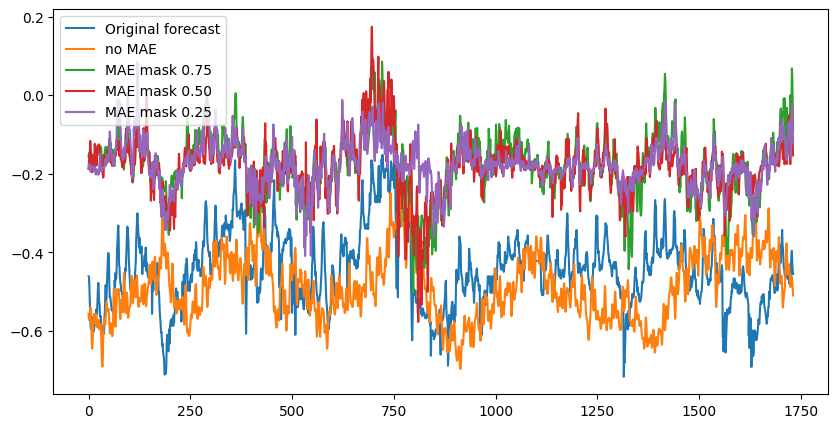

In [17]:
gt = y_test
p1 = predictions1.detach().numpy()
p2 = predictions2.detach().numpy()
p3 = predictions3.detach().numpy()
p4 = predictions4.detach().numpy()

plt.figure(figsize=(10,5))
plt.plot(gt,label='Original forecast')
plt.plot(p1,label='no MAE')
plt.plot(p2,label='MAE mask 0.75')
plt.plot(p3,label='MAE mask 0.50')
plt.plot(p4,label='MAE mask 0.25')
plt.legend(loc='upper left')
plt.show()

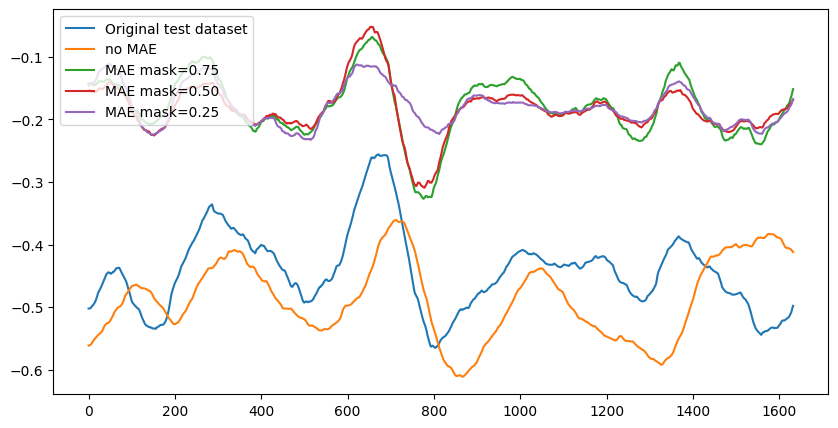

In [18]:
# Define a function to apply moving average smoothing
def moving_average(data, window_size):
    weights = np.repeat(1.0, window_size) / window_size
    return np.convolve(data, weights, 'valid')

# Smooth the original forecast, no MAE forecast, and MAE forecast
window_size = 100 # Adjust window size as needed
smoothed_gt = moving_average(gt.reshape(-1), window_size)
smoothed_p1 = moving_average(p1.reshape(-1), window_size)
smoothed_p2 = moving_average(p2.reshape(-1), window_size)
smoothed_p3 = moving_average(p3.reshape(-1), window_size)
smoothed_p4 = moving_average(p4.reshape(-1), window_size)


plt.figure(figsize=(10,5))
plt.plot(smoothed_gt,label='Original test dataset')
plt.plot(smoothed_p1,label='no MAE')
plt.plot(smoothed_p2,label='MAE mask=0.75')
plt.plot(smoothed_p3,label='MAE mask=0.50')
plt.plot(smoothed_p4,label='MAE mask=0.25')
plt.legend(loc='upper left')
plt.savefig("time_series_results.png")
plt.show()
